# Pet Image GAN Application
Contributors: Andrew Esch and Evan Lee

## Import Libraries

The goal of this project is to create realistic fake pet images, using the Oxford-IIIT Pet Dataset to create a GAN for generating pet images. This project will use TensorFlow, Keras, several math and image processing libraries, and system libraries.

In [44]:
# Tensorflow
import tensorflow as tf

# Keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout
from keras.optimizers import Adam

# Math and image libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# System libraries
import sys
import os

# Print library import verification message
print("All libraries successfully loaded!")

# Use gpus with Tensorflow if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU Device:", tf.config.experimental.get_visible_devices('GPU'))
    except RuntimeError as e:
        print(e)

All libraries successfully loaded!


## Gather Data and Set Constants
Next, after importing all of the libraries, the next step is to data and sets constants required for the GAN model. 

**IMPORTANT:** Before running this cell, make sure the Oxford-IIIT Pet Dataset is located in a folder called "images" at the root directory of this repository.

The following tasks are performed:

1. Model constants such as IMAGE_SIZE, LATENT_DIMENSION, BATCH_SIZE, EPOCHS, and EVALS are defined.
2. The main directory is assigned to the variable main_dir.
3. The location of the images is specified using the ImgLocation variable (change this variable if necessary).
4. An image category of interest is specified using the category variable (change this to any type of pet image, based on the starting keyphrase in the image).
5. A list of image paths that match the specified category is created and stored in ImagePaths.
6. The images are loaded, resized to a standard size, and converted to RGB format.
7. The standardized images are stored in the standard_images list after normalizing the pixel values by dividing by 255.
8. The shape of the standardized image data is printed to verify its dimensions.

In [45]:
# Define model constants
IMAGE_SIZE = 64  # Size of generated images
LATENT_DIMENSION = 100  # Size of the noise vector
BATCH_SIZE = 32  # Number of images in each batch
EPOCHS = 10  # Number of training epochs
EVALS = 100  # Number of training evaluations

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "\Pet-Image-GAN\images"
print("Saving Images to: " + ImgLocation)

# List image categories we are interested in
# Feel free to modify this value; Note that this will change the model
category = "Maine_Coon"

# Create a list to store image paths
ImagePaths = []
for image in os.listdir(ImgLocation):
    if category in image:
        ImagePaths.append(ImgLocation + "\\" + image)

# Load images and resize to a standard image size
standard_images = []
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    standard_image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    standard_images.append(standard_image)

# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
standard_images = np.array(standard_images, dtype="float") / 255.0

# Show data shape
print("Shape of standardized images:", standard_images.shape)

Saving Images to: c:\Users\Drew\OneDrive\Documents\github\Pet-Image-GAN\images
Shape of standardized images: (200, 64, 64, 3)


## Data Verification
To verify the images are loaded correctly and are standardized for this model, load a few sample images.

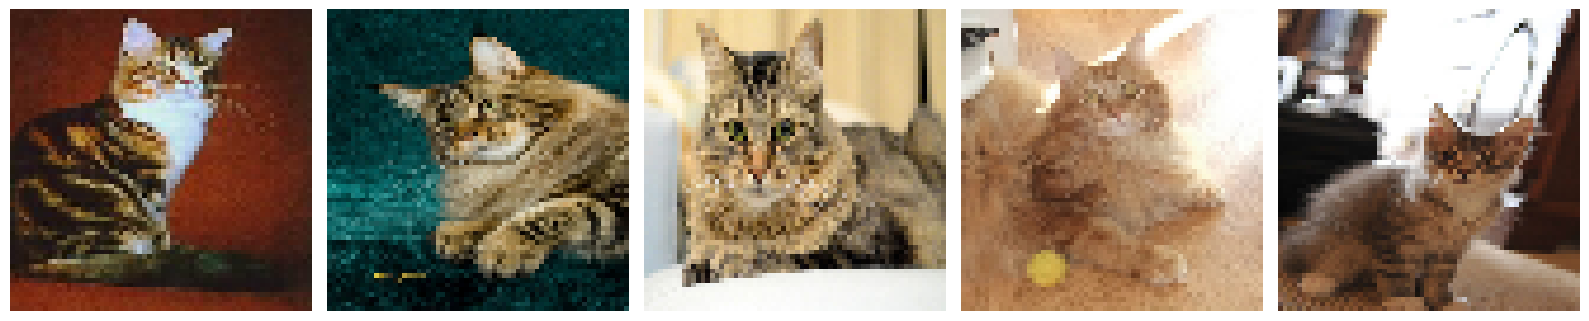

In [46]:
fig, axs = plt.subplots(1, 5, sharey=False, tight_layout=True, figsize=(16, 9), facecolor='white')

for i in range(5):
    axs[i].imshow(standard_images[i])
    axs[i].axis('off')

plt.show()

## 

## Generate Features with Data
Now that the images are loaded in this model, generate a fitted set of features for this data using the scalar method, and retransform it back to its original shape.

In [47]:
# Set the scaler for features
scaler=MinMaxScaler(feature_range=(-1, 1))

# Make a copy of the images for model training
data=standard_images.copy()

# Reshape array to 1D array and fit the data to the new features
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)
scaler.fit(data)

# Scale the array and reshape it back to their standard size
data=scaler.transform(data)
data=data.reshape(standard_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)

Reshaped data:  (2457600, 1)


## Build the GAN model
The Pet_GAN class is a class that implements a Generative Adversarial Network (GAN) for generating pet images. It consists of several methods that perform various tasks related to training and evaluating the GAN model.

### Initialization
The class constructor (__init__) initializes the GAN object with the specified image size (img_size) and latent dimension (latent). It also creates the generator, discriminator, and GAN models using the build_generator(), build_discriminator(), and build_gan() methods, respectively. Alternatively, pre-trained models can be loaded by providing their file paths as arguments.

### Model Building Methods
- The build_generator() method defines and returns the generator model, which takes random noise as input and generates pet images.
- The build_discriminator() method defines and returns the discriminator model, which classifies images as real or fake.
- The build_gan() method constructs and returns the GAN model, which combines the generator and discriminator models.

### Data Sampling Methods
- The real_samples() method randomly selects a specified number of real images (n) from the given dataset and returns them along with corresponding labels.
- The latent_vector() method generates a random noise vector of size n x latent_dim.
- The fake_samples() method generates a specified number of fake images (n) by passing the latent vectors through the generator model. It returns the generated images along with corresponding labels.

### Performance Evaluation Methods
- The performance_summary() method evaluates the performance of the discriminator on both real and generated images. It calculates and prints the accuracy of the discriminator on the real dataset and the generated pet images. It also showcases example predictions by displaying a grid of generated pet images.
- The predict() method generates and saves a specified number of example photos using the generator model. The images are saved with filenames appended with a number.
- The save() method saves the generator and discriminator models to the specified file paths.

### Training Method
The train() method trains the GAN model on the provided dataset. It takes the dataset, the number of epochs (n_epochs), batch size (n_batch), and the frequency of evaluation (n_eval) as input. During training, it alternates between training the discriminator and the generator. It prints the generator and discriminator losses at each epoch and calls the performance_summary() method to evaluate the model's performance on the dataset.

### Model Credits
Credits for the generator and discriminator model design from SolClover: https://github.com/SolClover/Art053_NN_DCGAN

In [48]:
class Pet_GAN:
    def __init__(self, img_size, latent, generate_model=None, discrim_model=None):
        self.image_size = img_size
        self.latent_dim = latent
        self.generator = self.build_generator() if generate_model is None else load_model(generate_model)
        self.discriminator = self.build_discriminator() if discrim_model is None else load_model(discrim_model)
        self.gan = self.build_gan()

    def build_generator(self):
        model = Sequential()
        model.add(Dense(8192, input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(ReLU())
        model.add(Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(ReLU())
        model.add(Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(ReLU())
        model.add(Conv2D(filters=3, kernel_size=(5, 5), activation='tanh', padding='same'))
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
        return model

    def build_gan(self):
        self.discriminator.trainable = False
        model = Sequential(name="DCGAN")
        model.add(self.generator)
        model.add(self.discriminator)
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
        return model

    def real_samples(self, n, dataset):
        indices = np.random.choice(dataset.shape[0], n, replace=True)
        X = dataset[indices]
        y = np.ones((n, 1))
        return X, y

    def latent_vector(self, n):
        latent_input = np.random.randn(n, self.latent_dim)
        return latent_input

    def fake_samples(self, n):
        latent_output = self.latent_vector(n)
        X = self.generator.predict(latent_output)
        y = np.zeros((n, 1))
        return X, y

    def performance_summary(self, dataset, n=50):
        x_real, y_real = self.real_samples(n, dataset)
        _, real_accuracy = self.discriminator.evaluate(x_real, y_real, verbose=0)

        x_fake, y_fake = self.fake_samples(n)
        _, fake_accuracy = self.discriminator.evaluate(x_fake, y_fake, verbose=0)

        print("Discriminator - Real Dataset Accuracy:", real_accuracy)
        print("Discriminator - Generated Pet Image Accuracy:", fake_accuracy)

        x_fake_inv_trans = x_fake.reshape(-1, 1)
        x_fake_inv_trans = scaler.inverse_transform(x_fake_inv_trans)
        x_fake_inv_trans = x_fake_inv_trans.reshape(n, self.image_size, self.image_size, 3)

        # Showcase example predictions
        _, axs = plt.subplots(2, 2, sharey=False, tight_layout=True, figsize=(12, 6), facecolor='white')
        k = 0
        for i in range(2):
            for j in range(2):
                axs[i, j].matshow(x_fake_inv_trans[k])
                k += 1
        plt.show()
    
    def predict(self, filename, n_predicts=1, n=50):
        x_fake, _ = self.fake_samples(n)

        x_fake_inv_trans = x_fake.reshape(-1, 1)
        x_fake_inv_trans = scaler.inverse_transform(x_fake_inv_trans)
        x_fake_inv_trans = x_fake_inv_trans.reshape(n, self.image_size, self.image_size, 3)

        # Create and save n number of example photos
        for i in range(n_predicts):
            fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(6, 6), facecolor='white')
            axs.matshow(x_fake_inv_trans[i])
            fig.savefig(f"{filename}_{i+1}.png")
            plt.close()

    def save(self, gen_model_saved, discrim_model_saved):
        self.generator.save(gen_model_saved)
        self.discriminator.save(discrim_model_saved)

    def train(self, dataset, n_epochs, n_batch, n_eval):
        half_batch = int(n_batch / 2)

        for i in range(n_epochs):
            x_real, y_real = self.real_samples(half_batch, dataset)
            x_fake, y_fake = self.fake_samples(half_batch)
            X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            discriminator_loss, _ = self.discriminator.train_on_batch(X, y)

            x_gan = self.latent_vector(n_batch)
            y_gan = np.ones((n_batch, 1))
            generator_loss = self.gan.train_on_batch(x_gan, y_gan)

            if i % n_eval == 0:
                print("Epoch:", i)
                print("Generator Loss:", generator_loss)
                print("Discriminator Loss:", discriminator_loss)
                self.performance_summary(dataset)



# Initialize Training and Run the Model
**NOTE: Skip this cell if the preference is to use a pre-trained model.**

Using n amount of epochs with a batch size of 32, contiuously train the model so that it can accurately generate realistically fake pet images.

1/1 [==============================] - 0s 476ms/step
Epoch: 0
Generator Loss: 1.8610658969464566e-07
Discriminator Loss: 8.424379348754883
2/2 [==============================] - 1s 382ms/step
Discriminator - Real Dataset Accuracy: 0.7400000095367432
Discriminator - Generated Pet Image Accuracy: 0.0


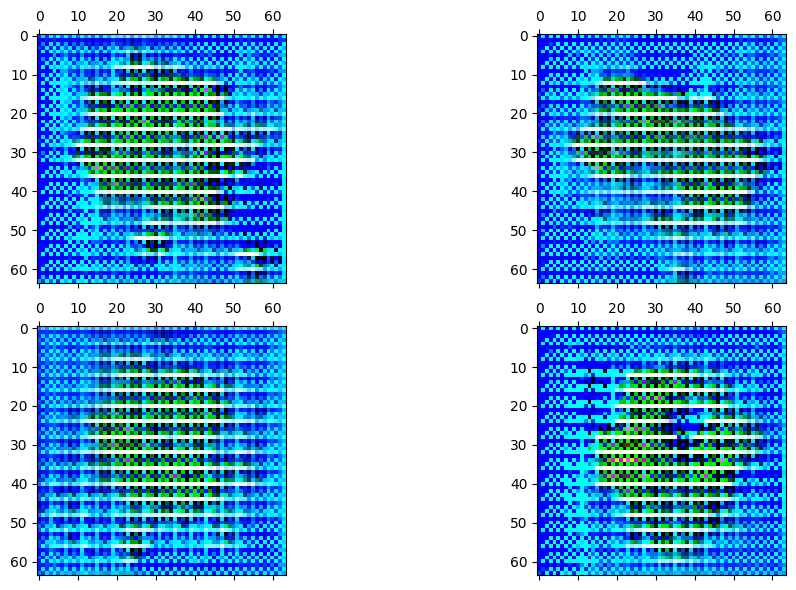

1/1 [==============================] - 0s 365ms/step


In [49]:
# Load an existing model, if it exists
generator_file = "pet_image_generator.h5"
discriminator_file = "pet_image_discriminator.h5"

if (os.path.exists(generator_file) and os.path.exists(discriminator_file)):
    gan = Pet_GAN(IMAGE_SIZE, LATENT_DIMENSION, generator_file, discriminator_file)
else:
    gan = Pet_GAN(IMAGE_SIZE, LATENT_DIMENSION)

# Train the Model
gan.train(data, EPOCHS, BATCH_SIZE, EVALS)

## Save Generator Model (Optional)

In [50]:
generator_file = "pet_image_generator.h5" # Change this you want the file name to be different
discriminator_file = "pet_image_discriminator.h5" # Change this you want the file name to be different
gan.save(generator_file, discriminator_file)

## Load Generator Model (Optional)
**NOTE: If you are using this program with a pretrained model, please run all of the cells prior to the "Training Initialization" cell first before running this cell.**

In [51]:
generator_file = "pet_image_generator.h5" # Change this if file name is different
discriminator_file = "pet_image_discriminator.h5" # Change this if file name is different
gan = Pet_GAN(IMAGE_SIZE, LATENT_DIMENSION, generator_file, discriminator_file)

## Generate Some Pet Images!

In [52]:
output_filename = ".\predictions\cat_image" # Change this to modify the location where this generates
num_images = 10 # Feel free to modify this number
gan.predict(output_filename, num_images)

2/2 [==============================] - 1s 462ms/step


## Analysis of Findings
Running the model for 1000 epochs, the model starts forming pixalated images that represent some context of pet images that all look the same. However, the model back-propogates and perceptrons are given different sets of weights, the predicted images become closer to the original dataset. It's clear by the complexity of the pet images though that the model requires thousands of epochs before the generated images will look close actual pet images.

Moreover, If a discriminator is too relaxed, pictures will be accepted that could not pass on good data to the next epoch. On the other hand, if the discriminator is too strict, the generator will have a hard time creating results that will pass on, adding more time to process for generated images to become closer to real pets.

## References
- https://www.geeksforgeeks.org/generative-adversarial-network-gan/
- https://www.educba.com/keras-batch-normalization/
- https://keras.io/api/layers/
- https://github.com/SolClover/Art053_NN_DCGAN